# Task 3: Customer Segmentation / Clustering


## Preprocess the data for clustering

In [2]:
import pandas as pd

# Load the datasets
customers_df = pd.read_csv('Downloads/Customers.csv')
transactions_df = pd.read_csv('Downloads/Transactions.csv')

# Convert transaction dates to datetime format
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Group transactions to calculate aggregated features for each customer
customer_transactions = transactions_df.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean', 'count'],  # Total spend, average spend, and transaction count
    'Quantity': 'sum'  # Total quantity purchased
}).reset_index()

# Flatten column names
customer_transactions.columns = [
    'CustomerID', 'TotalSpend', 'AverageSpend', 'TransactionCount', 'TotalQuantity'
]

# Merge aggregated transaction data with customer profile data
merged_df = pd.merge(customers_df, customer_transactions, on='CustomerID', how='left')

# Fill missing values (e.g., customers with no transactions)
merged_df.fillna({
    'TotalSpend': 0,
    'AverageSpend': 0,
    'TransactionCount': 0,
    'TotalQuantity': 0
}, inplace=True)

# Encode categorical variables like Region
merged_df = pd.get_dummies(merged_df, columns=['Region'], drop_first=True)

# Drop non-numeric columns that are not useful for clustering
processed_df = merged_df.drop(['CustomerID', 'CustomerName', 'SignupDate'], axis=1)

# Display the prepared data
print("Processed Data for Clustering:")
print(processed_df.head())


Processed Data for Clustering:
   TotalSpend  AverageSpend  TransactionCount  TotalQuantity  Region_Europe  \
0     3354.52       670.904               5.0           12.0          False   
1     1862.74       465.685               4.0           10.0          False   
2     2725.38       681.345               4.0           14.0          False   
3     5354.88       669.360               8.0           23.0          False   
4     2034.24       678.080               3.0            7.0          False   

   Region_North America  Region_South America  
0                 False                  True  
1                 False                 False  
2                 False                  True  
3                 False                  True  
4                 False                 False  


## Perform Clustering

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import numpy as np

# Prepare the data for clustering
clustering_data = processed_df.copy()

# Store the DB Index for each number of clusters
db_scores = {}
cluster_models = {}

# Perform clustering for clusters ranging from 2 to 10
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(clustering_data)
    db_index = davies_bouldin_score(clustering_data, cluster_labels)
    
    # Save the DB Index and clustering model
    db_scores[n_clusters] = db_index
    cluster_models[n_clusters] = kmeans

# Find the number of clusters with the lowest DB Index
optimal_clusters = min(db_scores, key=db_scores.get)

print("DB Index for each number of clusters:")
for k, v in db_scores.items():
    print(f"Number of Clusters: {k}, DB Index: {v}")

print(f"\nOptimal Number of Clusters (lowest DB Index): {optimal_clusters}")


DB Index for each number of clusters:
Number of Clusters: 2, DB Index: 0.5728313082343853
Number of Clusters: 3, DB Index: 0.6006918381606979
Number of Clusters: 4, DB Index: 0.60302862092278
Number of Clusters: 5, DB Index: 0.5772203449727893
Number of Clusters: 6, DB Index: 0.6118196929558593
Number of Clusters: 7, DB Index: 0.6577555718623502
Number of Clusters: 8, DB Index: 0.54488602663835
Number of Clusters: 9, DB Index: 0.617661067687435
Number of Clusters: 10, DB Index: 0.6326123911879158

Optimal Number of Clusters (lowest DB Index): 8


## Visualize the Clusters

C:\Users\morey\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


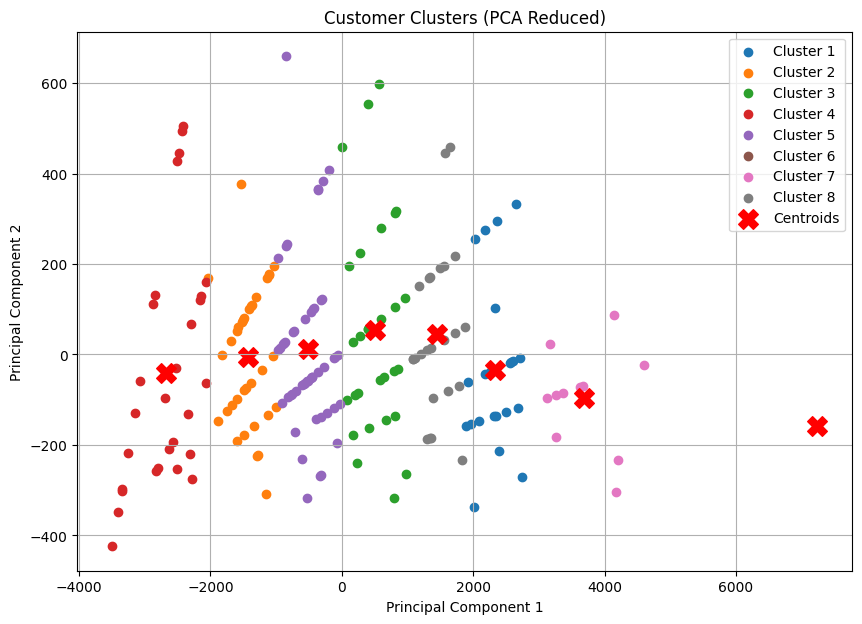

In [4]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Use the optimal number of clusters to get the cluster labels
optimal_kmeans = cluster_models[optimal_clusters]
cluster_labels = optimal_kmeans.labels_

# Reduce dimensions for visualization using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(clustering_data)

# Plot the clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_clusters):
    plt.scatter(
        reduced_data[cluster_labels == cluster, 0],
        reduced_data[cluster_labels == cluster, 1],
        label=f'Cluster {cluster + 1}'
    )

# Add cluster centers
centers = pca.transform(optimal_kmeans.cluster_centers_)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Centroids')

plt.title('Customer Clusters (PCA Reduced)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()


## Results and Clustering Metrics

In [5]:
# Summarize the results
print("Clustering Results Summary:")
print(f"Optimal Number of Clusters: {optimal_clusters}")
print(f"DB Index for Optimal Clusters: {db_scores[optimal_clusters]}")

# Optionally, calculate and print additional metrics like inertia (sum of squared distances to cluster centers)
inertia = optimal_kmeans.inertia_
print(f"Inertia (Sum of Squared Distances to Cluster Centers): {inertia}")

# Example insights based on clusters
print("\nCluster Insights:")
for cluster in range(optimal_clusters):
    cluster_data = clustering_data[cluster_labels == cluster]
    print(f"Cluster {cluster + 1}:")
    print(f" - Number of Customers: {len(cluster_data)}")
    print(f" - Average Total Spend: {cluster_data['TotalSpend'].mean():.2f}")
    print(f" - Average Transaction Count: {cluster_data['TransactionCount'].mean():.2f}")
    print()


Clustering Results Summary:
Optimal Number of Clusters: 8
DB Index for Optimal Clusters: 0.54488602663835
Inertia (Sum of Squared Distances to Cluster Centers): 26159270.226743646

Cluster Insights:
Cluster 1:
 - Number of Customers: 22
 - Average Total Spend: 5779.70
 - Average Transaction Count: 7.32

Cluster 2:
 - Number of Customers: 34
 - Average Total Spend: 2031.49
 - Average Transaction Count: 3.82

Cluster 3:
 - Number of Customers: 30
 - Average Total Spend: 3949.08
 - Average Transaction Count: 5.53

Cluster 4:
 - Number of Customers: 28
 - Average Total Spend: 788.77
 - Average Transaction Count: 1.96

Cluster 5:
 - Number of Customers: 50
 - Average Total Spend: 2932.66
 - Average Transaction Count: 4.80

Cluster 6:
 - Number of Customers: 1
 - Average Total Spend: 10673.87
 - Average Transaction Count: 10.00

Cluster 7:
 - Number of Customers: 11
 - Average Total Spend: 7138.43
 - Average Transaction Count: 8.36

Cluster 8:
 - Number of Customers: 24
 - Average Total Spen

## Export Results

In [8]:
import pandas as pd

# Create a DataFrame for DB Index scores
db_scores_df = pd.DataFrame(list(db_scores.items()), columns=['Number of Clusters', 'DB Index'])

# Paths to save the files in Downloads
output_path_clusters = 'Downloads/Customer_Clusters.csv'
output_path_db_scores = 'Downloads/DB_Index_Scores.csv'

# Save clustering results
merged_df.to_csv(output_path_clusters, index=False)
print(f"Clustering results saved as '{output_path_clusters}'.")

# Save DB Index scores
db_scores_df.to_csv(output_path_db_scores, index=False)
print(f"DB Index scores saved as '{output_path_db_scores}'.")


Clustering results saved as 'Downloads/Customer_Clusters.csv'.
DB Index scores saved as 'Downloads/DB_Index_Scores.csv'.
